In [105]:
import pandas as pd

df = pd.read_csv(r'block_0.csv')

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222670 entries, 0 to 1222669
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   LCLid           1222670 non-null  object
 1   tstp            1222670 non-null  object
 2   energy(kWh/hh)  1222670 non-null  object
dtypes: object(3)
memory usage: 28.0+ MB


In [107]:
df['tstp'] = pd.to_datetime(df['tstp'])

In [108]:
df['energy'] =pd.to_numeric(df['energy(kWh/hh)'],errors='coerce').astype('float32')

In [109]:
gp = df.groupby('LCLid')

In [110]:
df.head()

LCLid                tstp energy(kWh/hh)  energy
0  MAC000002 2012-10-12 00:30:00             0      0.0
1  MAC000002 2012-10-12 01:00:00             0      0.0
2  MAC000002 2012-10-12 01:30:00             0      0.0
3  MAC000002 2012-10-12 02:00:00             0      0.0
4  MAC000002 2012-10-12 02:30:00             0      0.0

In [111]:
df_1 = gp.get_group('MAC000246')

In [112]:
df_1.head()

LCLid                tstp energy(kWh/hh)  energy
24141  MAC000246 2011-12-03 09:00:00         0.149    0.149
24142  MAC000246 2011-12-03 09:30:00         0.154    0.154
24143  MAC000246 2011-12-03 10:00:00         0.768    0.768
24144  MAC000246 2011-12-03 10:30:00         1.179    1.179
24145  MAC000246 2011-12-03 11:00:00         0.588    0.588

In [113]:
df_1 = df_1.drop(['LCLid','energy(kWh/hh)'],axis=1)

In [114]:
df_1.head()

tstp  energy
24141 2011-12-03 09:00:00   0.149
24142 2011-12-03 09:30:00   0.154
24143 2011-12-03 10:00:00   0.768
24144 2011-12-03 10:30:00   1.179
24145 2011-12-03 11:00:00   0.588

In [115]:
df_1.set_index('tstp',inplace=True)

In [116]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39245 entries, 2011-12-03 09:00:00 to 2014-02-28 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  39244 non-null  float32
dtypes: float32(1)
memory usage: 459.9 KB


In [117]:
df_1['energy'].isna().sum()

1

In [118]:
import matplotlib.pyplot as plt

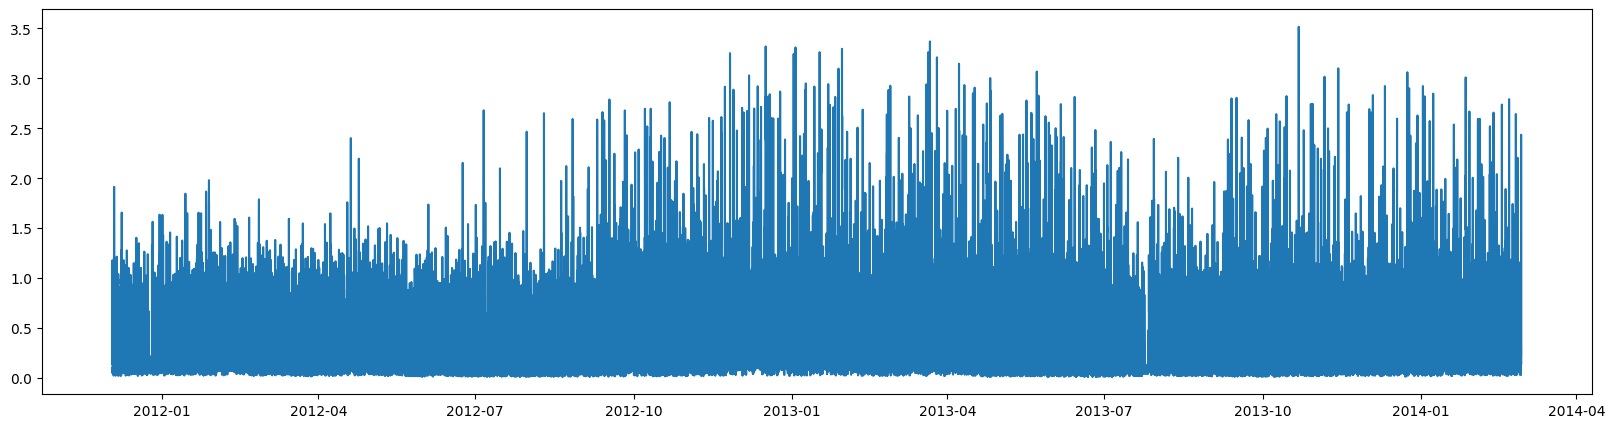

In [119]:
plt.figure(figsize=(20,5))
plt.plot(df_1.index,df_1)
plt.show()

In [120]:
df_1h = df_1.resample('1H')
df_1h = df_1h.mean()

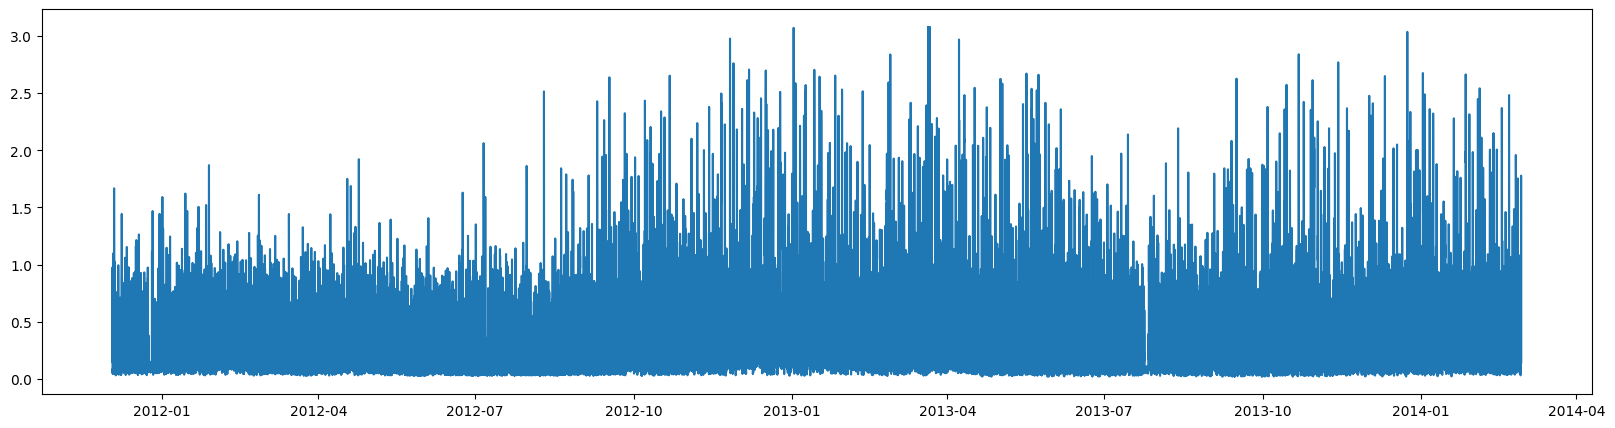

In [121]:
plt.figure(figsize=(20,5))
plt.plot(df_1h.index,df_1h)
plt.show()

In [122]:
df_1h.isna().sum()

energy    0
dtype: int64

In [123]:
df_1ha=df_1h.copy()

In [124]:
df_1h = (df_1h - df_1h.shift(1)).dropna()

In [125]:
rol_mean = df_1h.rolling(window=24).mean()
rol_std = df_1h.rolling(window=24).std()

In [126]:
rol_mean=rol_mean.rename(columns={'energy':'mean'})
r = pd.concat([df_1h,rol_mean,rol_std],axis=1)

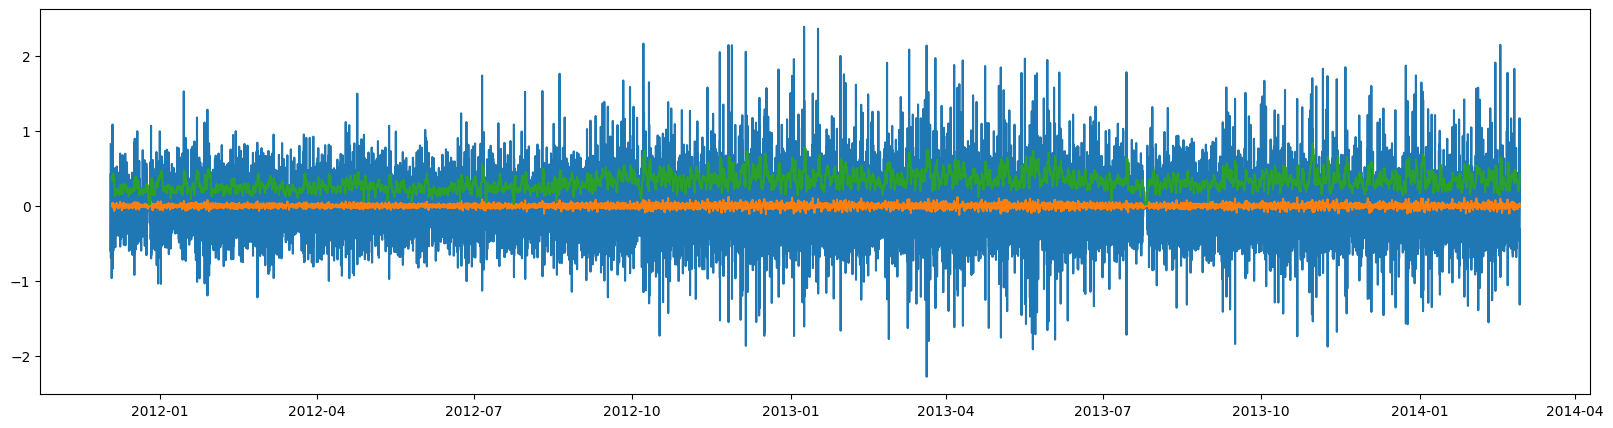

In [127]:
plt.figure(figsize=(20,5))
plt.plot(r.index,r)
plt.show()

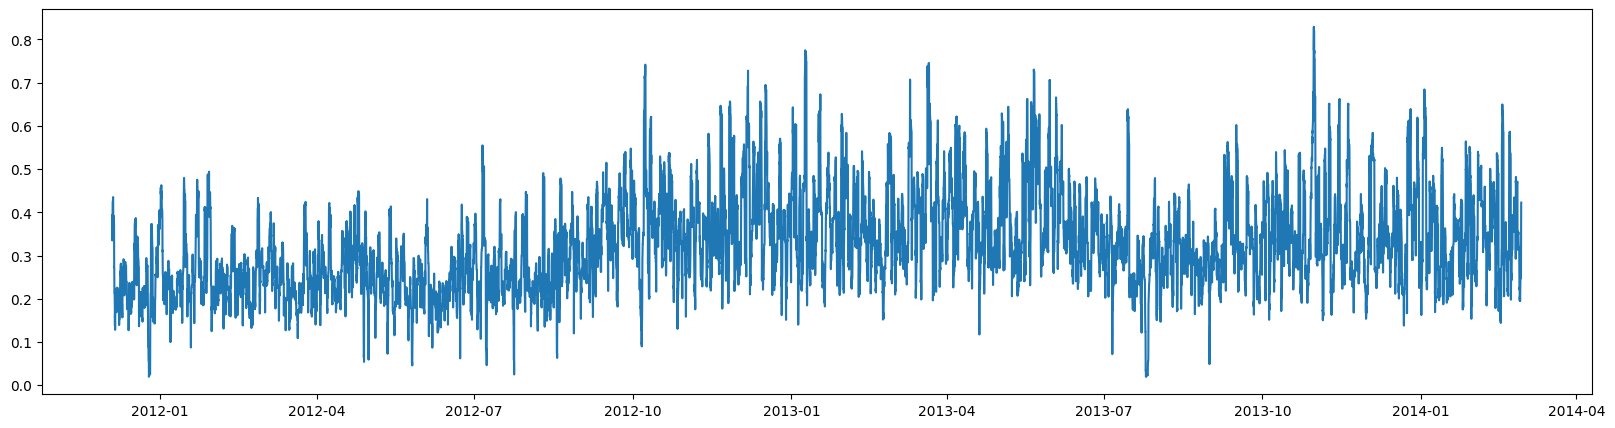

In [128]:
plt.figure(figsize=(20,5))
plt.plot(rol_std)
plt.show()

In [129]:
from statsmodels.tsa.stattools import adfuller

In [130]:
result=adfuller(df_1h)

In [131]:
print('adf_statistic:',result[0])

adf_statistic: -42.021259678346084


In [132]:
print(" p:",result[1])

 p: 0.0


In [133]:
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Critial Values:
   1%, -3.4306840735374164
Critial Values:
   5%, -2.861687648586539
Critial Values:
   10%, -2.5668485893387496


In [134]:
from statsmodels.tsa.seasonal import seasonal_decompose

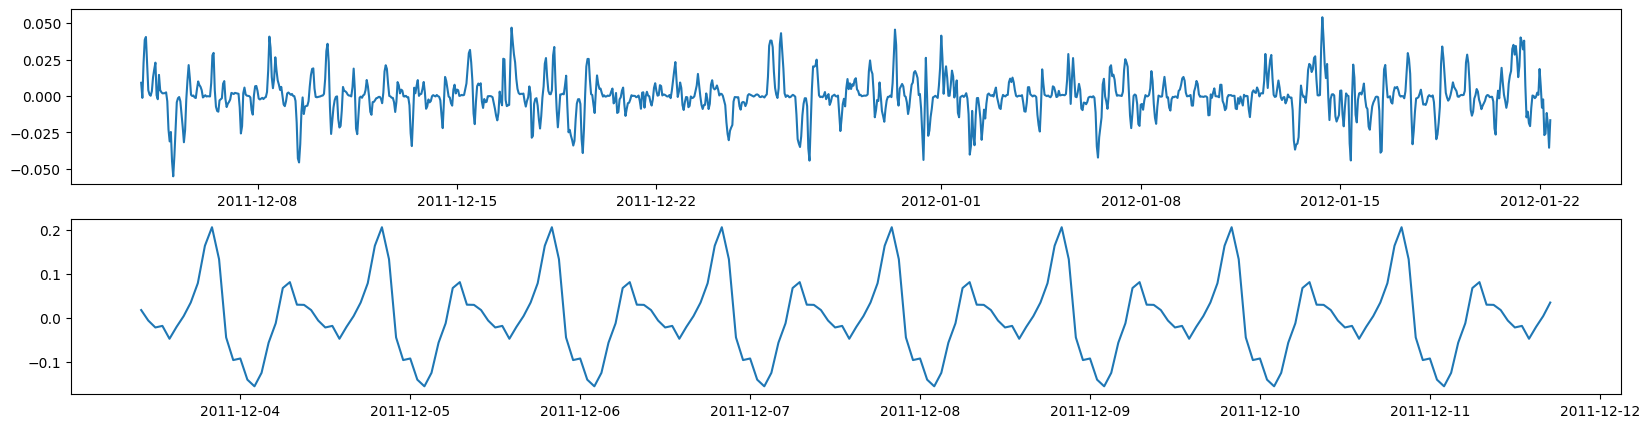

In [135]:
decompose=seasonal_decompose(df_1h)
trend=decompose.trend
seasonal=decompose.seasonal

plt.figure(figsize=(20,5))
plt.subplot(211)
plt.plot(trend[:1200])
plt.subplot(212)
plt.plot(seasonal[:200])
plt.show()

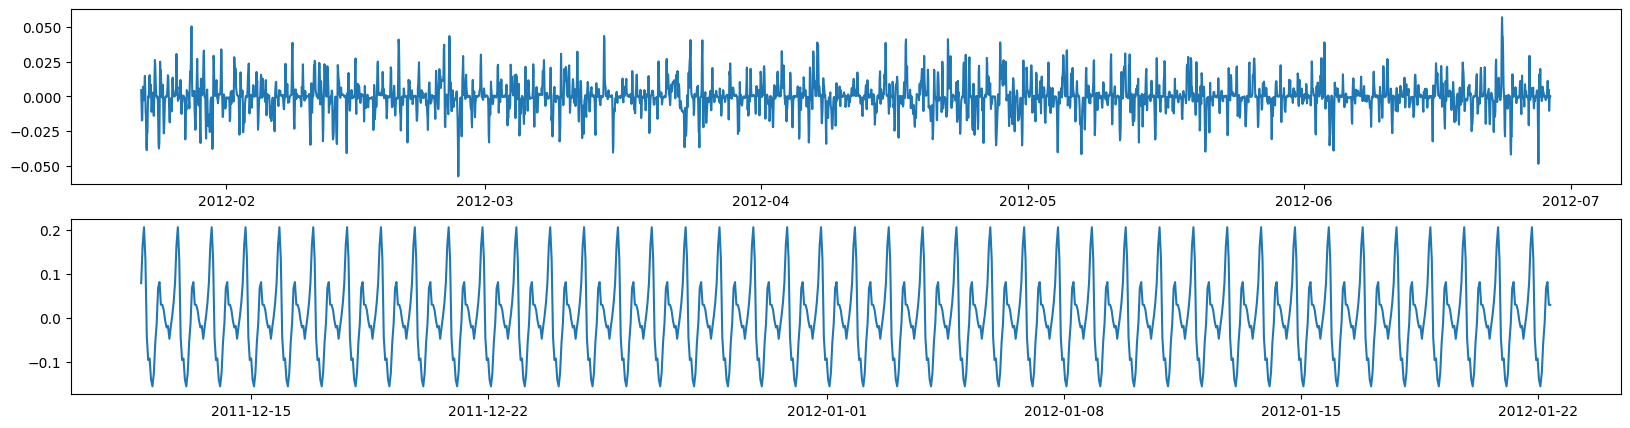

In [136]:
decompose=seasonal_decompose(df_1h)
trend=decompose.trend
seasonal=decompose.seasonal

plt.figure(figsize=(20,5))
plt.subplot(211)
plt.plot(trend[1200:5000])
plt.subplot(212)
plt.plot(seasonal[200:1200])
plt.show()

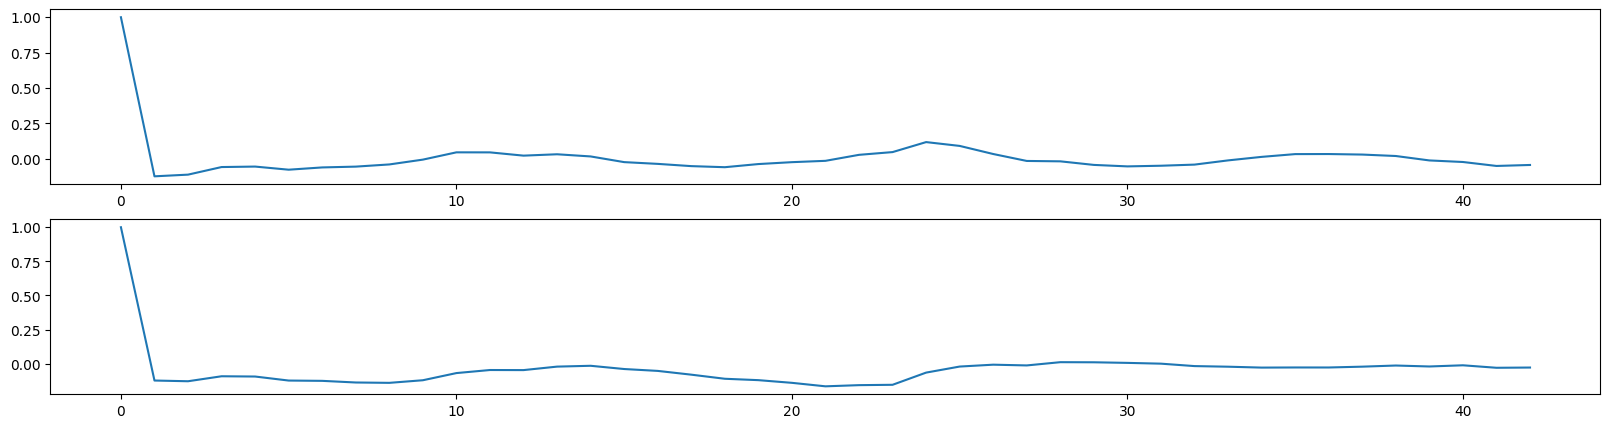

In [137]:
from statsmodels.tsa.stattools import acf,pacf

d_acf = acf(df_1h)
d_pacf = pacf(df_1h)
plt.figure(figsize=(20,5))
plt.subplot(211)
plt.plot(d_acf)
plt.subplot(212)
plt.plot(d_pacf)
plt.show()

In [138]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

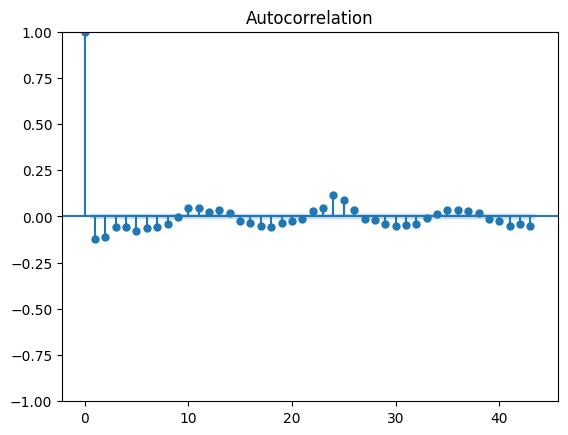

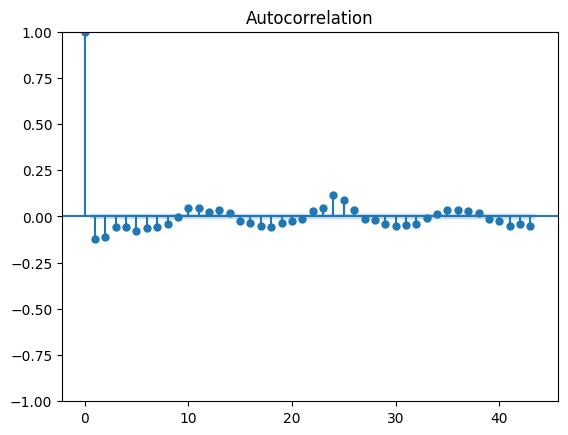

In [139]:
plot_acf(df_1h)

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


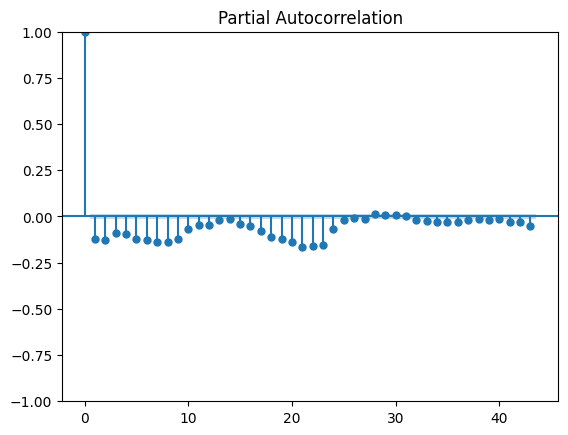

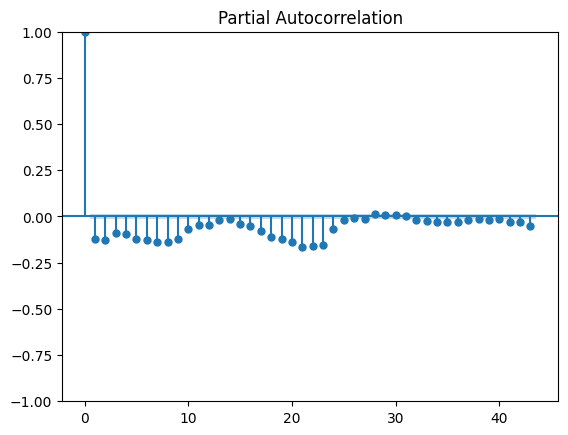

In [140]:
plot_pacf(df_1h)

p=1
d=0
q=3

In [141]:
from statsmodels.tsa.arima.model import ARIMA

In [142]:
model=ARIMA(df_1ha['energy'].iloc[:-(30*24)],order=(1,1,1),seasonal_order=(1,1,1,24))

In [143]:
re=model.fit()

In [144]:
print(re.summary())

                                    SARIMAX Results                                     
Dep. Variable:                           energy   No. Observations:                18904
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -3073.543
Date:                          Fri, 14 Apr 2023   AIC                           6157.086
Time:                                  15:56:51   BIC                           6196.315
Sample:                              12-03-2011   HQIC                          6169.957
                                   - 01-29-2014                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5038      0.004    125.015      0.000       0.496       0.512
ma.L1         -0.9984      0.000  -2330.177      0.

In [145]:
re_data=re.forecast(30*24,dynamic=False)

In [146]:
re_data=pd.DataFrame(re_data)

In [147]:
re_data.head()

predicted_mean
2014-01-29 01:00:00        0.722376
2014-01-29 02:00:00        0.426267
2014-01-29 03:00:00        0.223701
2014-01-29 04:00:00        0.167887
2014-01-29 05:00:00        0.121242

In [148]:
df_h=df_1ha['energy']

In [151]:
df_tot = pd.concat([df_h[:-(30*24)],re_data['predicted_mean']],axis=1)

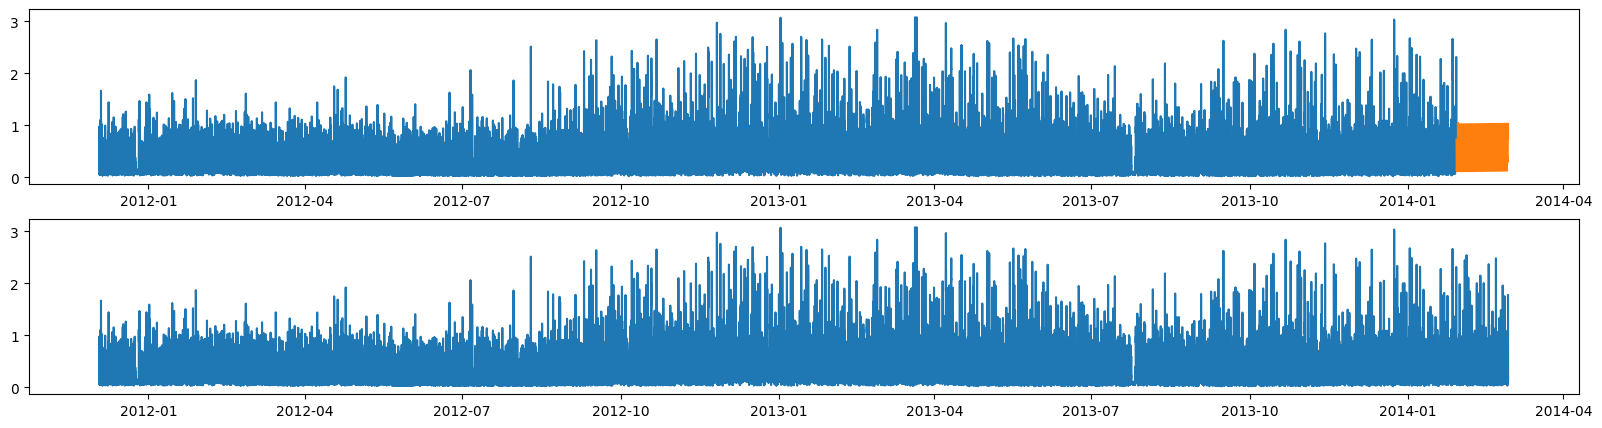

In [152]:
plt.figure(figsize=(20,5))
plt.subplot(211)
plt.plot(df_tot)
plt.subplot(212)
plt.plot(df_h)
plt.show()